In [1]:
import torch
from torch import nn, tensor
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import torchvision.transforms as T
from torchvision.ops import masks_to_boxes
from torchvision.transforms.functional import crop

/Users/yujiantang/Documents/workspace/fashionai/fai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions for Working with Image Data

In [2]:
def get_segmentation(extractor, model, image):
    inputs = extractor(images=image, return_tensors="pt")

    outputs = model(**inputs)
    logits = outputs.logits.cpu()

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]
    return pred_seg 

# returns two lists masks (tensor) and obj_ids (int)
# "mattmdjaga/segformer_b2_clothes" from hugging face
def get_masks(segmentation):
    obj_ids = torch.unique(segmentation)
    obj_ids = obj_ids[1:]
    masks = segmentation == obj_ids[:, None, None]
    return masks, obj_ids

def crop_images(masks, obj_ids, img):
    boxes = masks_to_boxes(masks)
    crop_boxes = []
    for box in boxes:
        crop_box = tensor([box[0], box[1], box[2]-box[0], box[3]-box[1]])
        crop_boxes.append(crop_box)
    
    preprocess = T.Compose([
        T.Resize(size=(256, 256)),
        T.ToTensor()
    ])
    
    cropped_images = {}
    for i in range(len(crop_boxes)):
        crop_box = crop_boxes[i]
        cropped = crop(img, crop_box[1].item(), crop_box[0].item(), crop_box[3].item(), crop_box[2].item())
        cropped_images[obj_ids[i].item()] = preprocess(cropped)
    return cropped_images

### Putting the Images into the Vector DB

In [3]:
extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/Users/yujiantang/Documents/workspace/fashionai/fai/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/Users/yujiantang/Documents/workspace/fashionai/fai/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


#### Looping through all the Images

In [4]:
import os

In [5]:
image_paths = []
for celeb in os.listdir("./photos"):
    for image in os.listdir(f"./photos/{celeb}/"):
        # print(image)
        image_paths.append(f"./photos/{celeb}/{image}")

In [6]:
from milvus import default_server
from pymilvus import utility, connections

In [7]:
default_server.start()



    __  _________ _   ____  ______
   /  |/  /  _/ /| | / / / / / __/
  / /|_/ // // /_| |/ / /_/ /\ \
 /_/  /_/___/____/___/\____/___/ {Lite}

 Welcome to use Milvus!

 Version:   v2.2.10-lite
 Process:   79581
 Started:   2023-06-22 08:30:49
 Config:    /Users/yujiantang/.milvus.io/milvus-server/2.2.10/configs/milvus.yaml
 Logs:      /Users/yujiantang/.milvus.io/milvus-server/2.2.10/logs

 Ctrl+C to exit ...


In [8]:
connections.connect(host="127.0.0.1", port=default_server.listen_port)

[__internal_register] retry:4, cost: 0.27s, reason: <_InactiveRpcError: StatusCode.UNAVAILABLE, internal: Milvus Proxy is not ready yet. please wait>
[__internal_register] retry:5, cost: 0.81s, reason: <_InactiveRpcError: StatusCode.UNAVAILABLE, internal: Milvus Proxy is not ready yet. please wait>


In [9]:
DIMENSION = 2048
BATCH_SIZE = 128
COLLECTION_NAME = "fashion"
TOP_K = 3

In [10]:
# run this before importing th resnet50 model if you run into an SSL certificate URLError
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
from pymilvus import FieldSchema, CollectionSchema, Collection, DataType

fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name="name", dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name="seg_id", dtype=DataType.INT64),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
]

schema = CollectionSchema(fields=fields)
collection = Collection(name=COLLECTION_NAME, schema=schema)

In [13]:
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {"nlist": 128},
}
collection.create_index(field_name="embedding", index_params=index_params)
collection.load()

In [11]:
# Load the embedding model with the last layer removed
embeddings_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
embeddings_model = torch.nn.Sequential(*(list(embeddings_model.children())[:-1]))
embeddings_model.eval()

Using cache found in /Users/yujiantang/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/yujiantang/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/Users/yujiantang/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel

In [14]:
def embed_insert(data, collection, model):
    with torch.no_grad():
        print(len(data[0]))
        print(data[0][0].size())
        output = model(torch.stack(data[0])).squeeze()
        print(type(output))
        print(len(output))
        print(len(output[0]))
        print(output[0])
    collection.insert([data[1], data[2], data[3], output.tolist()])

In [15]:
from PIL import Image

In [16]:
data_batch = [[], [], [], []]

for path in image_paths:
    image = Image.open(path)
    path_split = path.split("/")
    name = " ".join(path_split[2].split("_"))
    segmentation = get_segmentation(extractor, model, image)
    masks, ids = get_masks(segmentation)
    cropped_images = crop_images(masks, ids, image)
    for key, image in cropped_images.items():
        data_batch[0].append(image)
        data_batch[1].append(path)
        data_batch[2].append(name)
        data_batch[3].append(key)
        if len(data_batch[0]) % BATCH_SIZE == 0:
            embed_insert(data_batch, collection, embeddings_model)
            data_batch = [[], [], [], []]

if len(data_batch[0]) != 0:
    embed_insert(data_batch, collection, embeddings_model)

collection.flush()


128
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
128
2048
tensor([0.0000, 0.4412, 0.0326,  ..., 0.2693, 0.5054, 0.0173])
128
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
128
2048
tensor([0.0000, 0.2864, 0.0041,  ..., 0.0766, 0.0000, 0.0103])
128
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
128
2048
tensor([9.0128e-02, 5.9042e-02, 3.2170e-04,  ..., 2.3349e-02, 3.8650e-01,
        3.0170e-02])
128
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
128
2048
tensor([0.0000, 0.0185, 0.4186,  ..., 0.0078, 0.1084, 0.0069])
128
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
128
2048
tensor([0.0151, 0.0555, 0.6485,  ..., 0.2089, 0.0186, 0.0000])
128
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
128
2048
tensor([0.0204, 0.0695, 0.2007,  ..., 0.0879, 0.8508, 0.1558])
128
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
128
2048
tensor([0.3128, 0.4963, 0.0000,  ..., 0.0293, 0.1871, 0.0000])
37
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
37
2048
tensor([0.0000, 0.2212, 0.1322,  

### Querying the Vector DB

#### transform the input image

In [18]:
def embed_search_images(data, model):
    with torch.no_grad():
        print(len(data[0]))
        print(data[0][0].size())
        output = model(torch.stack(data))
        print(type(output))
        print(len(output))
        print(len(output[0]))
        print(output[0])
        if len(output) > 1:
            return output.squeeze().tolist()
        else:
            return torch.flatten(output, start_dim=1).tolist()

In [19]:
# data_batch[0] is a list of tensors
# data_batch[1] is a list of filepaths to the images (string)
# data_batch[2] is a list of the names of the people in the images (string)
# data_batch[3] is a list of segmentation keys (int)
data_batch = [[], [], [], []]

search_paths = ["./photos/Taylor_Swift/Taylor_Swift_3.jpg", "./photos/Taylor_Swift/Taylor_Swift_8.jpg"]

for path in search_paths:
    image = Image.open(path)
    path_split = path.split("/")
    name = " ".join(path_split[2].split("_"))
    segmentation = get_segmentation(extractor, model, image)
    masks, ids = get_masks(segmentation)
    cropped_images = crop_images(masks, ids, image)
    for key, image in cropped_images.items():
        data_batch[0].append(image)
        data_batch[1].append(path)
        data_batch[2].append(name)
        data_batch[3].append(key)

embeds = embed_search_images(data_batch[0], embeddings_model)

3
torch.Size([256, 256])
<class 'torch.Tensor'>
23
2048
tensor([[[0.0258]],

        [[0.0000]],

        [[0.7185]],

        ...,

        [[0.0420]],

        [[0.1010]],

        [[0.0000]]])


In [20]:
import time

In [21]:
start = time.time()
res = collection.search(embeds, 
                        anns_field='embedding', 
                        param={"metric_type": "L2",
                               "params": {"nprobe": 10}}, 
                        limit=TOP_K, 
                        output_fields=['filepath'])
finish = time.time()
print(finish - start)

0.13793611526489258


In [22]:
for index, result in enumerate(res):
    print(index)
    print(result)

0
["id: 442354329014764640, distance: 0.0, entity: {'filepath': './photos/Taylor_Swift/Taylor_Swift_3.jpg'}", "id: 442354329014764645, distance: 190.94537353515625, entity: {'filepath': './photos/Taylor_Swift/Taylor_Swift_3.jpg'}", "id: 442354329014764699, distance: 222.36871337890625, entity: {'filepath': './photos/Taylor_Swift/Taylor_Swift_6.jpg'}"]
1
["id: 442354329014764641, distance: 0.0, entity: {'filepath': './photos/Taylor_Swift/Taylor_Swift_3.jpg'}", "id: 442354329014764649, distance: 237.70457458496094, entity: {'filepath': './photos/Taylor_Swift/Taylor_Swift_3.jpg'}", "id: 442354329014764709, distance: 332.40484619140625, entity: {'filepath': './photos/Taylor_Swift/Taylor_Swift_6.jpg'}"]
2
["id: 442354329014764642, distance: 0.0, entity: {'filepath': './photos/Taylor_Swift/Taylor_Swift_3.jpg'}", "id: 442354329014764041, distance: 324.70379638671875, entity: {'filepath': './photos/Selena_Gomez/Selena_Gomez_4.jpg'}", "id: 442354329014764296, distance: 326.4505615234375, entity

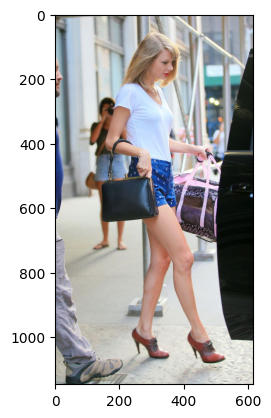

In [22]:
plt.imshow(Image.open(data_batch[1][0]))

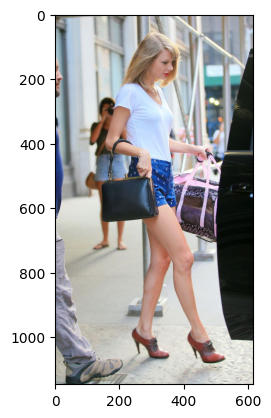

In [35]:
plt.imshow(Image.open(res[0][0].entity.filepath))

In [24]:
if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)

In [25]:
default_server.stop()
default_server.cleanup()